IMPORTING MODULES

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torchinfo import summary

from tqdm.auto import tqdm
from timeit import default_timer as timer

import requests
import zipfile
import pathlib
from pathlib import Path

import random 
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import os

from typing import Tuple, Dict, List

HYPERPARAMETERS

In [14]:
INPUT_SHAPE = 3
HIDDEN_UNITS = 10
OUPUT_SHAPE = 3

BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_WORKERS = 0
EPOCHS = 10
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

Downloading Dataset

In [4]:
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
    print(f"{image_path} directory already exists")
else:
    print(f"creating {image_path}...")
    image_path.mkdir(parents=True, exist_ok=True)

with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza, steak, sushi data...")
    f.write(request.content)

with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print(f"Unziping pizza, steak, sushi data...")
    zip_ref.extractall(image_path)

print("DONE!")


data/pizza_steak_sushi directory already exists
Unziping pizza, steak, sushi data...
DONE!


SETTING DATA

pizza
Random image path: data/pizza_steak_sushi/test/pizza/2236338.jpg
Image class: pizza
Image height: 512
Image width: 512


(-0.5, 511.5, 511.5, -0.5)

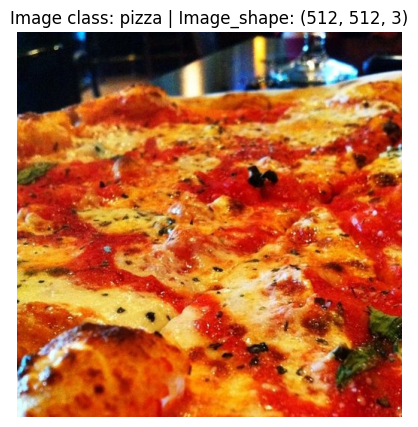

In [5]:
train_dir = image_path / "train"
test_dir = image_path / "test"

random.seed(42)
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# Pick a random image path
random_image_path = random.choice(image_path_list)

# Get image class from path name 
image_class = random_image_path.parent.stem
print(image_class)

# Open image
img = Image.open(random_image_path)

# Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")

img_as_array = np.array(img)

plt.figure(figsize=(5, 5))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image_shape: {img_as_array.shape}")
plt.axis(False)

CREATING A CUSTOM DATASET

In [6]:
class ImageFolderCustom(Dataset):
    
    def __find_classes(self, directory: str) -> Tuple[List[str], Dict[str, int]]:
        # Get the class names by scanning the target directory
        classes = sorted([entry.name for entry in list(os.scandir(directory))])
        
        # Raise an error if class names coult not be found
        if not classes:
            raise FileNotFoundError(f"!Couldn't find any classes in {directory}!\nPlease check file structure")
        
        # Create a dictionary of index labels
        class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
        
        return classes, class_to_idx

    def __init__(self, targ_dir: str, transform=None):
        # Get all of the image paths
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
        # Setup transform
        self.transform = transform
        # Create classes and class_to_idx attributes
        self.classes, self.class_to_idx = self.__find_classes(targ_dir)
    
    def load_image(self, index: int) -> Image.Image:
        image_path = self.paths[index]
        return Image.open(image_path)
    
    def __len__(self) -> int:
        return len(self.paths)
    
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        img = self.load_image(index)
        class_name = self.paths[index].parent.name
        class_idx = self.class_to_idx[class_name]
        
        if self.transform:
            return self.transform(img), class_idx
        else:
            return img, class_idx


In [7]:
train_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transform)
test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transform)

train_dataloader = DataLoader(dataset=train_data_custom,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data_custom,
                             batch_size=8,
                             num_workers=NUM_WORKERS,
                             shuffle=False)

img, label = next(iter(train_dataloader))
img, label

(tensor([[[[0.3137, 0.3098, 0.2902,  ..., 0.0667, 0.0588, 0.0588],
           [0.3137, 0.3020, 0.1490,  ..., 0.0588, 0.0549, 0.0549],
           [0.3137, 0.3059, 0.2902,  ..., 0.0588, 0.0471, 0.0588],
           ...,
           [0.0196, 0.0353, 0.0471,  ..., 0.6588, 0.6078, 0.5725],
           [0.0078, 0.0235, 0.0392,  ..., 0.6314, 0.5961, 0.5608],
           [0.0039, 0.0196, 0.0392,  ..., 0.6078, 0.5725, 0.5412]],
 
          [[0.4627, 0.4510, 0.3608,  ..., 0.0706, 0.0706, 0.0706],
           [0.4549, 0.4078, 0.2471,  ..., 0.0510, 0.0706, 0.0706],
           [0.4353, 0.4078, 0.3176,  ..., 0.0510, 0.0510, 0.0706],
           ...,
           [0.0392, 0.0902, 0.1294,  ..., 0.7608, 0.7373, 0.7216],
           [0.0118, 0.0275, 0.1020,  ..., 0.7451, 0.7294, 0.7137],
           [0.0039, 0.0157, 0.0510,  ..., 0.7294, 0.7216, 0.7059]],
 
          [[0.3608, 0.3608, 0.3294,  ..., 0.1843, 0.2235, 0.2235],
           [0.4353, 0.3725, 0.2235,  ..., 0.1412, 0.1412, 0.2235],
           [0.5255, 0.50

VISUALIZING DATASET

In [8]:
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    # Adjust display if n is too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10. Setting to 10 and removing shape display.")

    # Set the seed
    if seed:
        random.seed(seed)

    # Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # Setup plot
    plt.figure(figsize=(16, 8))

    # Loop through random indexes and plot them
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # Adjust tensor dimensions for plotting
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"Class: {classes[targ_label]}({targ_sample})"
            if display_shape:
                title = title + f"\nShape: {targ_image_adjust.shape}"
        plt.title(title)  

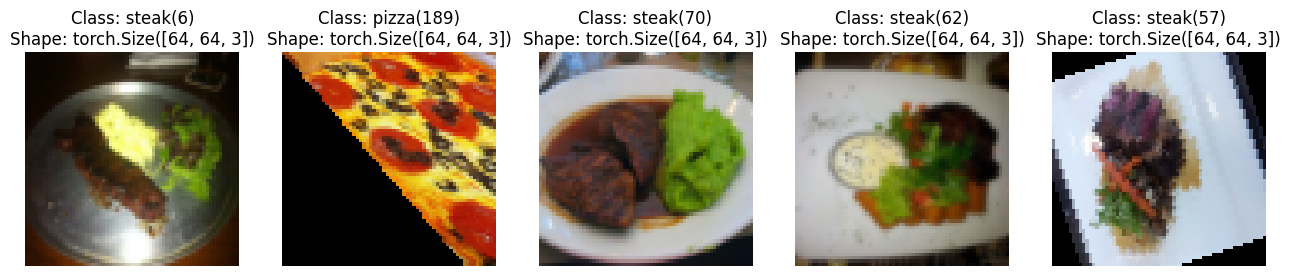

In [9]:
display_random_images(train_data_custom,
                      n=5,
                      classes=train_data_custom.classes,
                      seed=None)

CREATING A MODEL

In [10]:
class FoodCustomModel(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*13*13, out_features=output_shape)
        )
    def forward(self, x):
        return self.classifier(self.block_2(self.block_1(x)))
    
model = FoodCustomModel(input_shape=INPUT_SHAPE,
                        hidden_units=HIDDEN_UNITS,
                        output_shape=OUPUT_SHAPE).to(DEVICE)

image_batch, label_batch = next(iter(train_dataloader))
summary(model, input_size=image_batch.shape)

Layer (type:depth-idx)                   Output Shape              Param #
FoodCustomModel                          [32, 3]                   --
├─Sequential: 1-1                        [32, 10, 30, 30]          --
│    └─Conv2d: 2-1                       [32, 10, 62, 62]          280
│    └─ReLU: 2-2                         [32, 10, 62, 62]          --
│    └─Conv2d: 2-3                       [32, 10, 60, 60]          910
│    └─ReLU: 2-4                         [32, 10, 60, 60]          --
│    └─MaxPool2d: 2-5                    [32, 10, 30, 30]          --
├─Sequential: 1-2                        [32, 10, 13, 13]          --
│    └─Conv2d: 2-6                       [32, 10, 28, 28]          910
│    └─ReLU: 2-7                         [32, 10, 28, 28]          --
│    └─Conv2d: 2-8                       [32, 10, 26, 26]          910
│    └─ReLU: 2-9                         [32, 10, 26, 26]          --
│    └─MaxPool2d: 2-10                   [32, 10, 13, 13]          --
├─Sequentia

TRAIN AND TEST

In [13]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: str = DEVICE) -> Tuple[float, float]:
    model.train()

    loss, acc = 0, 0

    for batch, X, y in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss += loss_fn(y_pred, y).item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        acc += (y_pred_class == y).sum().item() / len(y_pred)
    
    loss /= len(dataloader)
    acc /= len(dataloader)
    return loss, acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: str = DEVICE) -> Tuple[float, float]:
    model.eval()

    loss, acc = 0, 0

    with torch.inference_mode():
        for batch, X, y in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y).item()
            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)

            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            acc += (y_pred_class == y).sum().item() / len(y_pred)
        
    loss /= len(dataloader)
    acc /= len(dataloader)
    return loss, acc

def train(model: torch.nn.Module,
          train_data: torch.utils.data.DataLoader,
          test_data: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: str = DEVICE) -> None:
    
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_data,
                                           optimizer=optimizer,
                                           loss_fn=loss_fn,
                                           device=device)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_data,
                                        loss_fn=loss_fn,
                                        device=device)
        print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

In [12]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=0.001)

start_time = timer()
model_results = train(model=model,
                      train_data=train_dataloader,
                      test_data=test_dataloader,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=EPOCHS,
                      device=DEVICE)
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")